In [11]:
# General
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

# EDA
from pandas_profiling import ProfileReport

# With missforest we can use random forest to impute data. This is better than mean by far
# to avoid errors on loading missingpy
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics

# Model to apply
import xgboost as xgb # need to set manually what variables are categorical

# Oversampling
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# load stored data from data_imputation
%store -r data_frame_imputed
data_frame = data_frame_imputed.copy()

# data from uri
%store -r X_train
X_train = X_train.copy()
%store -r y_train
y_train = y_train.copy()

%store -r X_test
X_test = X_test.copy()
%store -r y_test
y_test = y_test.copy()

# Removing ID

In [14]:
X_train = X_train.drop('ID', axis = 1)
X_test = X_test.drop('ID', axis = 1)

# Oversampling

In [15]:
# define oversampling strategy
SMOTE = SMOTE()

# Transformamos la variable y
# Sustituyo el nombre para no cambiar todo el código
X_train, y_train = SMOTE.fit_resample(X_train, y_train)

## Training & validation with xgboost

In [16]:
# build the lightgbm model

val_model = xgb.XGBClassifier(learning_rate = 0.09, max_depth = 5, random_state = 1) # lgb.LGBMClassifier() or LGBMRanker()
val_model.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],
          eval_metric='auc')

[0]	validation_0-auc:0.74559	validation_1-auc:0.54572
[1]	validation_0-auc:0.75558	validation_1-auc:0.54394
[2]	validation_0-auc:0.76767	validation_1-auc:0.54647


/Users/hectorcozar/Documents/GitHub/caixabank/venv/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-auc:0.77226	validation_1-auc:0.54731
[4]	validation_0-auc:0.78141	validation_1-auc:0.54725
[5]	validation_0-auc:0.78339	validation_1-auc:0.54593
[6]	validation_0-auc:0.78818	validation_1-auc:0.54708
[7]	validation_0-auc:0.79453	validation_1-auc:0.54859
[8]	validation_0-auc:0.79850	validation_1-auc:0.54976
[9]	validation_0-auc:0.80406	validation_1-auc:0.55373
[10]	validation_0-auc:0.81235	validation_1-auc:0.55629
[11]	validation_0-auc:0.81507	validation_1-auc:0.55739
[12]	validation_0-auc:0.81797	validation_1-auc:0.55897
[13]	validation_0-auc:0.81996	validation_1-auc:0.56003
[14]	validation_0-auc:0.82407	validation_1-auc:0.56141
[15]	validation_0-auc:0.82805	validation_1-auc:0.56387
[16]	validation_0-auc:0.82986	validation_1-auc:0.56561
[17]	validation_0-auc:0.83331	validation_1-auc:0.56898
[18]	validation_0-auc:0.83615	validation_1-auc:0.57070
[19]	validation_0-auc:0.83763	validation_1-auc:0.57228
[20]	validation_0-auc:0.84003	validation_1-auc:0.57504
[21]	validation_0

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [17]:
print('Training AUC {:.4f}'.format(val_model.score(X_train,y_train)))
print('Testing AUC {:.4f}'.format(val_model.score(X_test,y_test)))

Training AUC 0.8290
Testing AUC 0.8213


<AxesSubplot:title={'center':'Feature importance'}, xlabel='AUC', ylabel='Features'>

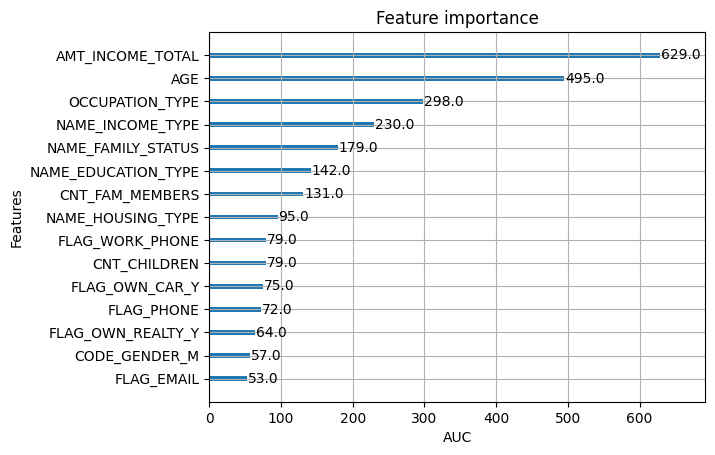

In [18]:
xgb.plot_importance(val_model, xlabel= "AUC", max_num_features = 30)


<AxesSubplot:>

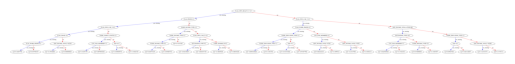

In [19]:
xgb.plot_tree(val_model)


In [24]:
from sklearn.model_selection import cross_val_score


data = cross_val_score(val_model, X_train, y_train, cv = 5, scoring= "roc_auc")
data

array([0.84680875, 0.91828442, 0.91570153, 0.92408078, 0.91563267])

## Submission with the validation model.

## Full model submission

Once we have validated the model splitting train and test we are going to train the final model with all the train data we have. 